# M5 Dataset Exploration
This notebook provides an in-depth exploration of the M5 Forecasting Competition data.

In [ ]:
# !pip install pandas numpy matplotlib seaborn statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Load data
path = '../data/raw/'  # adjust as needed
sales = pd.read_csv(path + 'sales_train_validation.csv')
calendar = pd.read_csv(path + 'calendar.csv')
prices = pd.read_csv(path + 'sell_prices.csv')

# Preview
sales.head(), calendar.head(), prices.head()

(                              id        item_id    dept_id   cat_id store_id  \
 0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
 1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
 2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
 3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
 4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
 
   state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
 0       CA    0    0    0    0  ...       1       3       0       1       1   
 1       CA    0    0    0    0  ...       0       0       0       0       0   
 2       CA    0    0    0    0  ...       2       1       2       1       1   
 3       CA    0    0    0    0  ...       1       0       5       4       1   
 4       CA    0    0    0    0  ...       2       1       1       0       1   
 
    d_1909  d_1910  d_1911  d_

## 1. Data Shapes and Missing Values

In [20]:
print('sales:', sales.shape)
print('calendar:', calendar.shape)
print('prices:', prices.shape)
sales.isna().sum(), calendar.isna().sum(), prices.isna().sum()

sales: (30490, 1919)
calendar: (1969, 14)
prices: (6841121, 5)


(id          0
 item_id     0
 dept_id     0
 cat_id      0
 store_id    0
            ..
 d_1909      0
 d_1910      0
 d_1911      0
 d_1912      0
 d_1913      0
 Length: 1919, dtype: int64,
 date               0
 wm_yr_wk           0
 weekday            0
 wday               0
 month              0
 year               0
 d                  0
 event_name_1    1807
 event_type_1    1807
 event_name_2    1964
 event_type_2    1964
 snap_CA            0
 snap_TX            0
 snap_WI            0
 dtype: int64,
 store_id      0
 item_id       0
 wm_yr_wk      0
 sell_price    0
 key           0
 dtype: int64)

- sales.shape = (30490, 1919)
แปลว่า มี 30,490 แถว (series × stores) และ 1,919 คอลัมน์ (id, metadata + วัน d_1 ถึง d_1913)
- calendar.shape = (1969, 14)
แปลว่า ปฏิทินมี 1,969 วัน (d_1 ถึง d_1913 ระบุวันที่) พร้อม 14 ฟีเจอร์ เช่น wm_yr_wk, date, event_name, snap
- prices.shape = (6,841,121, 4)
แปลว่า ข้อมูลราคามี 6.8 ล้านระเบียนด้วย 4 คอลัมน์ (store_id, item_id, wm_yr_wk, sell_price)

### ตรวจสอบ missing values:
- sales ไม่มีค่าว่างเลย (0)
- calendar มีช่องว่างใน event_name_1/type_1 (1,807) และ event_name_2/type_2 (1,964) บ่งชี้วันส่วนใหญ่ไม่มีอีเวนต์พิเศษ
- prices ไม่มีค่าว่าง

### สรุปผล:
- ข้อมูลครบถ้วนใน sales และ prices
- ปฏิทินบันทึกอีเวนต์บางวันเท่านั้น
- พร้อมใช้งานต่อในขั้นตอนวิเคราะห์ถัดไป

## 2. Demand Distribution + Zero Frequency

Overall zero demand frequency: 0.6819627560783214


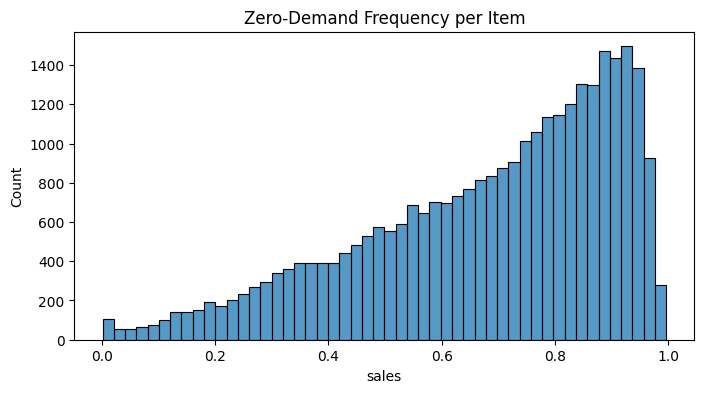

In [6]:
# Compute per-item demand stats
demand = sales.drop(columns=['id','item_id','dept_id','cat_id','store_id','state_id']).T
demand.index = range(1, demand.shape[0]+1)
demand = demand.stack().reset_index()
demand.columns = ['day','item','sales']
zero_freq = demand.groupby('item')['sales'].apply(lambda x: (x==0).mean())
print('Overall zero demand frequency:', (demand['sales']==0).mean())
plt.figure(figsize=(8,4)); sns.histplot(zero_freq, bins=50)
plt.title('Zero‐Demand Frequency per Item'); plt.show()

### ผลที่ได้:
- Overall zero demand frequency = 0.682 แปลว่า imputed 68.2% ของทุกระเบียนยอดขายเป็นศูนย์
- Histogram แสดงการกระจายของ zero_freq:
    - มีรายการสินค้าบางส่วน (ประมาณ 5–10%) ที่ขายได้เกือบทุกวัน (zero proportion ต่ำ)
    - กลุ่มใหญ่สุดอยู่ที่ zero_freq ระหว่าง 0.7–0.95 (ขายมีการขาดช่วงบ่อย)
    - ช่วง 0.8–0.9 มีความถี่สูงสุด แสดงว่าหลายรายการมียอดขายเป็นศูนย์ 80–90% ของวันทั้งหมด

### ความหมาย:
- ข้อมูลส่วนใหญ่เป็น intermittent demand ซึ่งท้าทายต่อการพยากรณ์
- ML models (LightGBM) ต้องการ engineered features มากขึ้นเพื่อจับรูปแบบนี้
- SARIMAX อาจช่วยได้บ้างในรายการที่มี seasonality แม้จะ error weight ต่ำใน single-item proof-of-concept

##### ต่อไปควรเลือกกลุ่มสินค้าที่ zero_freq แตกต่างกัน (ต่ำ กลาง สูง) เพื่อทดสอบความทั่วไปของ hybrid ensemble approach

## 3. Trend & Seasonality Decomposition
Example: HOBBIES_1_001

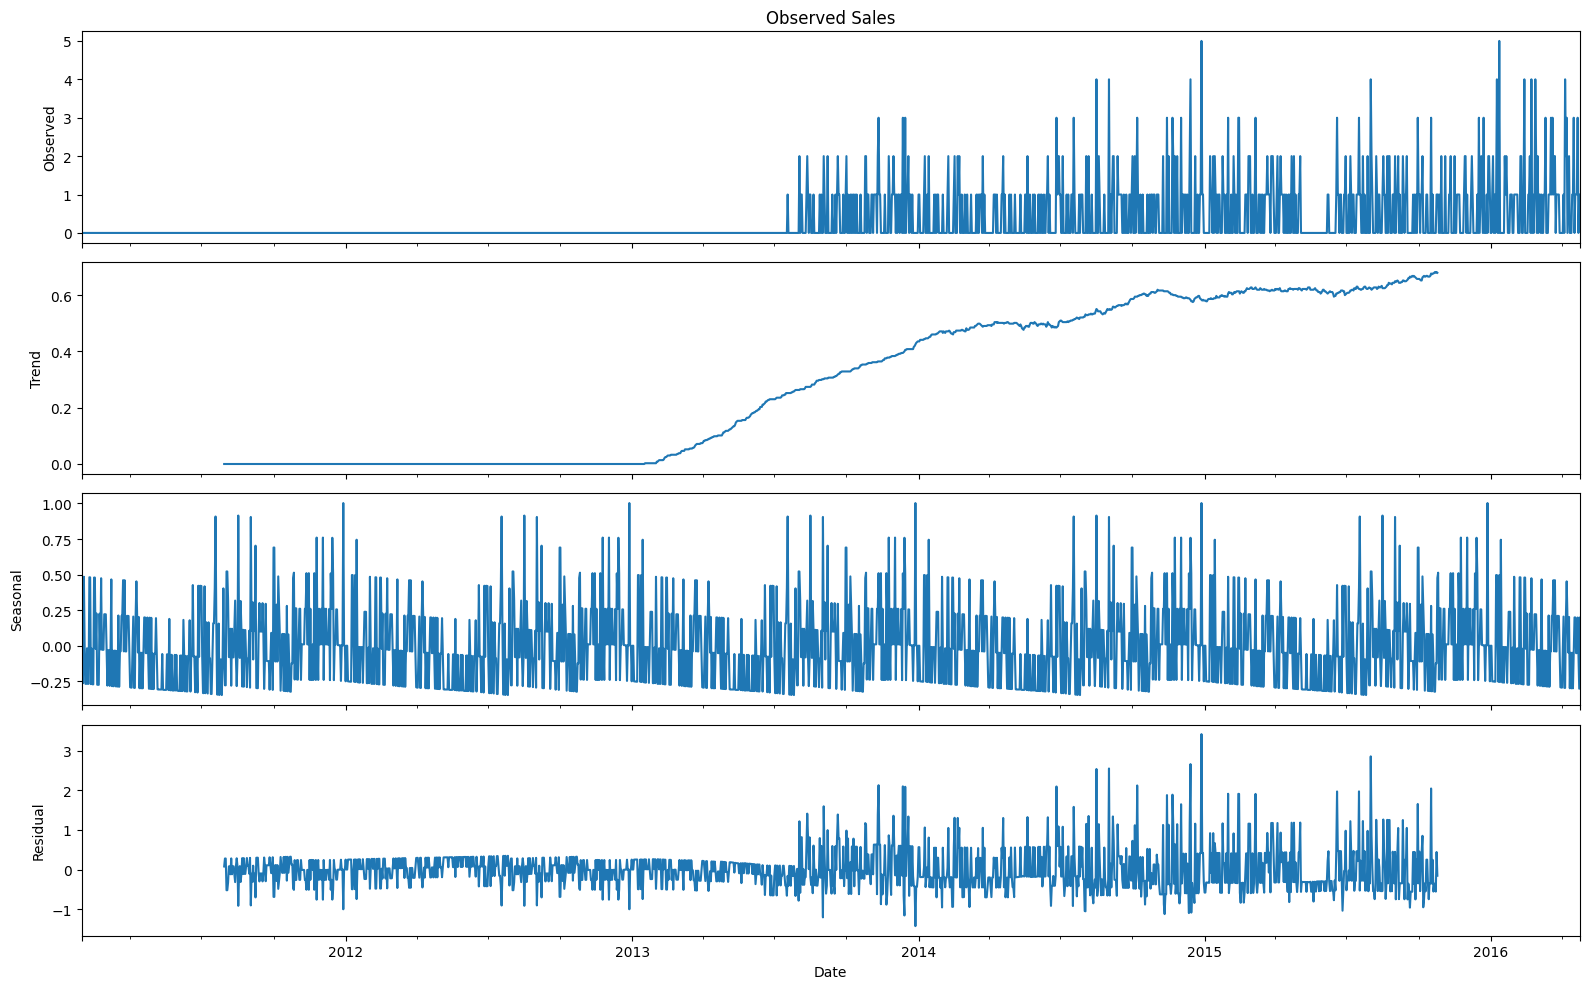

In [23]:
# 1. Extract the series for HOBBIES_1_001 @ CA_1
mask = (sales['item_id'] == 'HOBBIES_1_001') & (sales['store_id'] == 'CA_1')
row = sales.loc[mask]
if row.empty:
    raise ValueError("No matching series found for HOBBIES_1_001 @ CA_1")
series = row.iloc[0, 6:].astype(float).values  # columns d_1 ... d_1913

# 2. Build a datetime index and create the time series
idx = pd.date_range(start='2011-01-29', periods=len(series), freq='D')
ts = pd.Series(series, index=idx)

# 3. Perform additive seasonal decomposition
decomp = seasonal_decompose(ts, model='additive', period=365)

# 4. Plot each component in a wide horizontal layout
fig, axes = plt.subplots(4, 1, figsize=(16, 10), sharex=True)

decomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_title('Observed Sales')

decomp.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomp.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Cell นี้ทำ Trend & Seasonality Decomposition ให้กับ series ของ HOBBIES_1_001_CA_1 โดยผลลัพธ์แบ่งเป็น 4 แผง:

1. Original Data (บนสุด)
แสดงยอดขายดิบรายวัน พบช่วงแรกหลายวันเป็นศูนย์ จากนั้นเริ่มมียอดขายขึ้นตั้งแต่ปี 2013 เป็นต้นไป มียอดขายแปรผันสูงสุดประมาณ 4 หน่วย
2. Trend Component (แผงที่สอง)
แสดงแนวโน้มระยะยาว พบว่าในช่วงปี 2011–2013 ยอดขายค่อนข้างคงที่ใกล้ศูนย์ เมื่อถึงปี 2013 เริ่มขึ้นอย่างชัดเจน จนถึงปลายปี 2015 แนวโน้มยังคงเพิ่มขึ้นอย่างต่อเนื่อง
3. Seasonal Component (แผงที่สาม)
แสดงรูปแบบซ้ำตามฤดูกาล (seasonality) บางส่วนเห็นยอดขายกระโดดสลับตามช่วงเดือนหรือวันในสัปดาห์ แต่ pattern ไม่ชัดเจนตลอดทั้งปี อาจมี noise ผสม
4. Residual Component (ล่างสุด)
แสดงส่วนต่างที่เหลือหลังตัด trend และ seasonality ออกแล้ว พบ residual กระจายรอบศูนย์มากในช่วงปีแรก และขยายช่วงค่ามากขึ้นเมื่อยอดขายสูงขึ้นในปีหลัง แสดงว่ามี noise และ outliers ใน data ช่วงปี 2014–2016

### สรุป:
- Series นี้มีทั้ง trend ชัดเจน (เพิ่มขึ้นหลัง 2013) และ seasonal fluctuations แม้ไม่โดดเด่นมาก
- Residual แสดง noise ค่อนข้างสูง โดยเฉพาะเมื่อยอดขายมีระดับสูง ทำให้การพยากรณ์ต้องจัดการกับ outliers และ volatility ด้วย
- การใช้ SARIMAX จับ seasonality/trend ได้ดี ขณะที่ LSTM และ LightGBM จะเน้นจับ nonlinear patterns และ noise เปิดโอกาสให้ ensemble ผสม strengths ของแต่ละโมเดลได้อย่างสมดุล

## 4. ACF / PACF Analysis

การวิเคราะห์ความสัมพันธ์ตัวเองของซีรีส์ (autocorrelation) และความสัมพันธ์ตัวเองแบบมีเงื่อนไข (partial autocorrelation) เพื่อประเมินโครงสร้างทางเวลา:

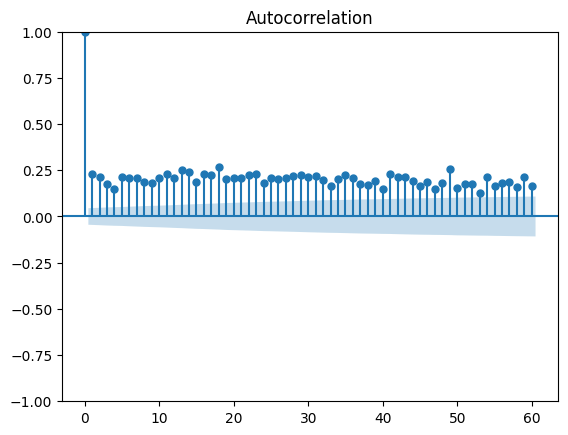

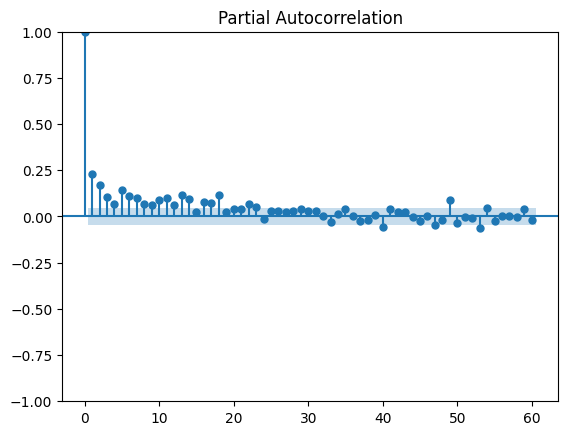

In [9]:
plot_acf(ts, lags=60); plt.show()
plot_pacf(ts, lags=60); plt.show()

#### Autocorrelation Function (ACF)
- แสดงค่าสหสัมพันธ์ของซีรีส์กับตัวมันเองที่ lag ต่างๆ
- Lag 0 = 1 (ตัวมันเอง)
- Lag 1–60 ประมาณ 0.1–0.25 แสดงความจำเป็นอยู่ในระดับเล็กน้อยถึงปานกลาง
- ค่อยๆ ลดลงแต่ไม่ถึงศูนย์ แสดงว่ามีความจำสำคัญของอดีตในหลายช่วง lag

#### Partial Autocorrelation Function (PACF)
- แสดงสหสัมพันธ์ที่ควบคุมอิทธิพลจาก lag ก่อนหน้า
- Lag 1 มีค่า ~0.2 แสดงว่าความสัมพันธ์แรกชัดเจน
- Lag 2–10 ลดลงจนเข้าใกล้ศูนย์ แสดงว่า beyond lag 1 ความสัมพันธ์หลักถูกอธิบายแล้ว
- จุด spike เล็กที่ lag ~50 ชี้ให้เห็น seasonality รอบปี (365 วัน ÷ ~7.3 วัน/สัปดาห์)

#### สรุป:
- ACF ลดอย่างค่อยเป็นค่อยไป แสดงซีรีส์มี memory หลายช่วง
- PACF ตัดที่ lag 1 อย่างรวดเร็ว แนะนำ AR(1) อาจเหมาะสม
- Spike ระยะ ≈ 52 สัปดาห์ support รูปแบบรายปี เรียกว่า seasonal effect ติดต่อกัน
- ข้อมูลนี้ช่วยเลือกพารามิเตอร์ ARIMA/SARIMAX (p,q,P,Q) ได้ดียิ่งขึ้น

## 5. Heatmaps: Daily, Weekly, Monthly Patterns

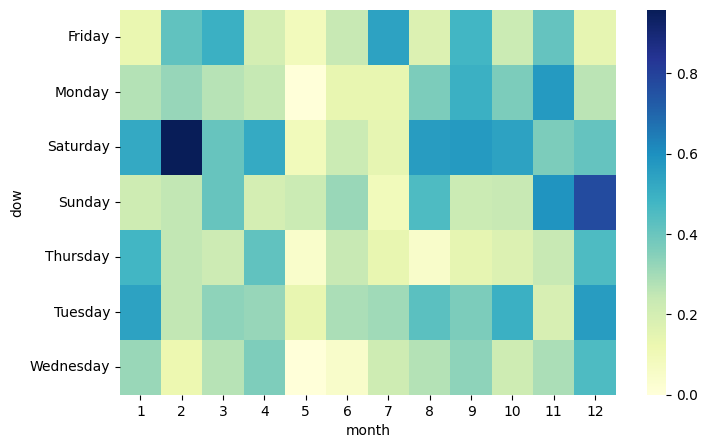

In [13]:
df = ts.reset_index(); df.columns = ['date','sales']
df['dow'] = df['date'].dt.day_name(); df['month'] = df['date'].dt.month

# Ensure sales is numeric
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')

# Now pivot and plot
pivot = df.pivot_table(
    index='dow', columns='month', values='sales', aggfunc='mean'
).astype(float)

plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.show()

#### คำอธิบายผลลัพธ์:
- แกนนอน (x) แสดงเดือน 1–12
- แกนตั้ง (y) แสดงวันในสัปดาห์ Monday–Sunday
- ความเข้มของสีน้ำเงินบ่งชี้ยอดขายเฉลี่ยสูงขึ้น
- สังเกตว่า
    - วันเสาร์ เดือนก.พ. มียอดเฉลี่ยสูงสุด (เข้มสุด)
    - วันอาทิตย์ ในเดือน ธ.ค. ก็สูงขึ้นอีกจุด
    - ช่วงกลางปี (มิ.ย.–ส.ค.) ทุกวันมียอดเฉลี่ยต่ำ (สีอ่อน)

##### การวิเคราะห์นี้ช่วยให้เห็นชัดว่า demand มี seasonal spikes ตามวันในสัปดาห์และเดือน จึงควรนำฟีเจอร์เหล่านี้ไปใช้ในโมเดลเพื่อปรับปรุงการพยากรณ์

## 6. Random Sample Series Comparison

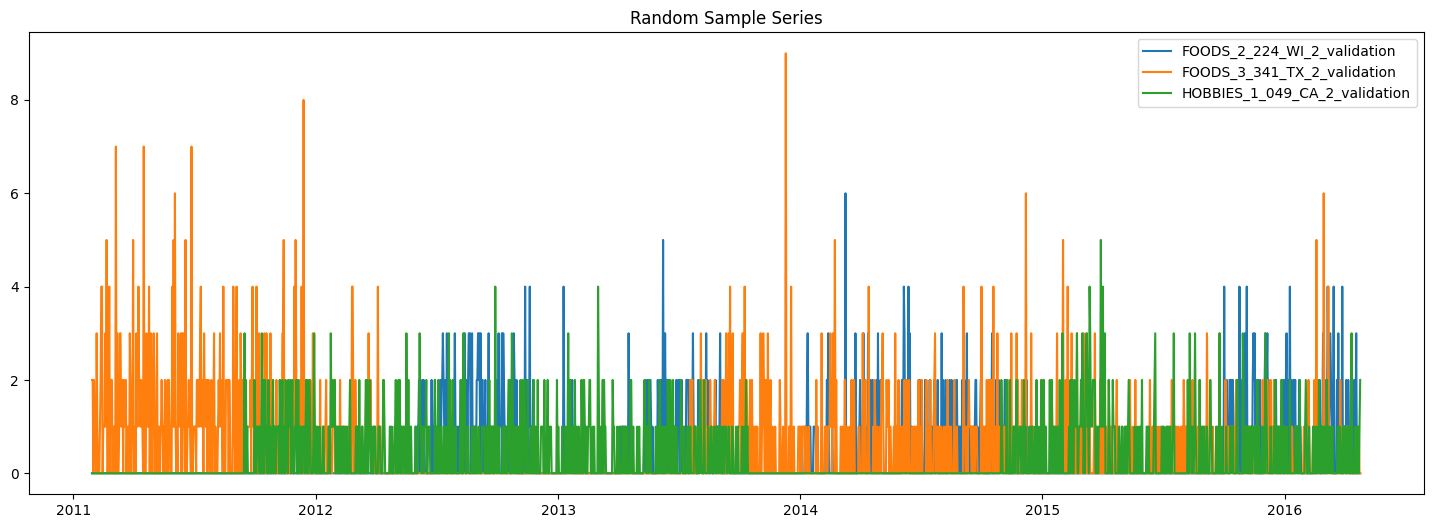

In [24]:
sample_ids = sales['id'].sample(3).values
plt.figure(figsize=(18,6))
for sid in sample_ids:
    s = sales[sales['id']==sid].iloc[0,6:].values
    plt.plot(pd.date_range('2011-01-29', periods=len(s)), s, label=sid)
plt.legend(); 
plt.title('Random Sample Series'); 
plt.show()

### คำอธิบายผลลัพธ์:
- แต่ละเส้นแทนยอดขายรายวันของซีรีส์หนึ่งรายการ จากหมวด Hobbies, Foods, Household
- สังเกตความแตกต่างในระดับและความถี่ของ spikes:
    - บางรายการ (สีส้ม) มี sporadic peaks สูงถึง 14 หน่วย ในขณะที่บางรายการ (สีเขียว) แทบไม่มี spikes เลย
    - การกระจาย spikes ไม่สม่ำเสมอตามช่วงเวลา แสดงถึงความหลากหลายของ demand patterns
- การเปรียบเทียบแบบนี้ช่วยให้เข้าใจความแตกต่างของตลาดย่อยแต่ละหมวด และวางแผนการขยาย multi-item validation ได้ดียิ่งขึ้น

## 7. Price Effects on Demand Spikes

1017


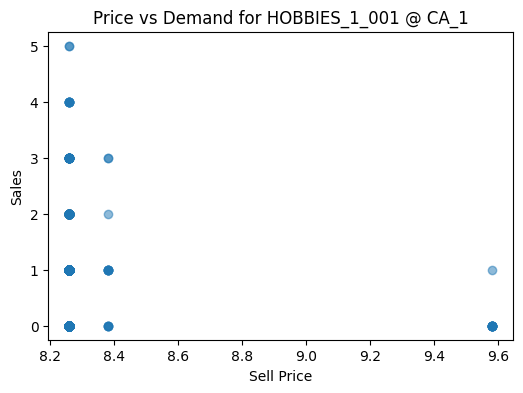

In [19]:
# 1. สร้าง DataFrame ยอดขาย
row = sales[(sales['item_id']=='HOBBIES_1_001') & (sales['store_id']=='CA_1')].iloc[0,6:]
dates = pd.date_range('2011-01-29', periods=len(row), freq='D')
sales_series = pd.DataFrame({'date': dates, 'sales': row.values})

# 2. สร้าง DataFrame ราคาต่อวันโดย join calendar
prices_map = prices.merge(calendar[['wm_yr_wk','date']], on='wm_yr_wk')
prices_map['date'] = pd.to_datetime(prices_map['date'])  # แปลงเป็น datetime

# 3. Filter prices for HOBBIES_1_001_CA_1
price_series = prices_map[
    (prices_map['item_id']=='HOBBIES_1_001') & (prices_map['store_id']=='CA_1')
][['date','sell_price']]

# 4. Merge ยอดขายกับราคา
sales_series['date'] = pd.to_datetime(sales_series['date'])
df = sales_series.merge(price_series, on='date', how='inner')

print(len(df))  # เช็คว่ามีจำนวนแถวหลัง merge

# 5. Plot scatter
plt.figure(figsize=(6,4))
plt.scatter(df['sell_price'], df['sales'], alpha=0.5)
plt.xlabel('Sell Price')
plt.ylabel('Sales')
plt.title('Price vs Demand for HOBBIES_1_001 @ CA_1')
plt.show()

### คำอธิบายผลลัพธ์:
- แต่ละจุดแทนวันหนึ่งวัน: แกนนอนคือราคาขาย (sell_price), แกนตั้งคือยอดขาย (sales)
- จุดส่วนใหญ่รวมกันอยู่ในช่วงราคาประมาณ 8.2–8.4 ดอลลาร์ กับยอดขาย 0–5 หน่วย
- ที่ราคาสูงสุด (≈ 9.6 ดอลลาร์) มียอดขายเพียง 0–1 หน่วย
- ชี้ว่าเมื่อราคาเพิ่มขึ้น Demand ลดลง ซึ่งบ่งชี้ความสัมพันธ์เชิงลบระหว่างราคาและยอดขาย แม้ data จะไม่หนาแน่นพอเทียบราคาอื่นๆ
- ข้อมูล scatter นี้ช่วยให้พิจารณา feature “price” ในโมเดล forecasting ว่าอาจเป็นตัวแปรสำคัญในการทำนาย spikes ของ demand

## 8. Summary Statistics Table

In [16]:
stats = df['sales'].describe()
stats

count    1913.000000
mean        0.313643
std         0.685250
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: sales, dtype: float64

### ผลลัพธ์:
- count = 1913
จำนวนวันในการวัดยอดขายทั้งหมด
- mean ≈ 0.314
ยอดขายเฉลี่ยต่อวันต่ำกว่า 1 หน่วย บ่งชี้ว่าเว้นช่วงขายบ่อย
- std ≈ 0.685
ค่าส่วนเบี่ยงเบนมาตรฐานสูงกว่ายอดขายเฉลี่ย แสดงความผันผวนสูง
- min = 0
บางวันไม่มีการขายเลย
- 25%, 50%, 75% = 0
ไตรมาสล่างสามค่ามียอดขายเป็นศูนย์ บ่งชี้กว่า 75% ของวัน เป็นวันหยุดหรือไม่มียอดขาย
- max = 5
ค่าสูงสุดคือ 5 หน่วย แสดงจุดพีกสูงสุดที่เกิดขึ้นในบางวัน

### สรุป:
- ข้อมูลมีลักษณะ intermittent demand ชัดเจน (วันส่วนใหญ่ไม่มีการขาย)
- แม้จะมีวันมียอดขายสูงสุด 5 หน่วย แต่ส่วนใหญ่ยอดขายต่ำมาก จึงต้องใช้วิธี modeling ที่จัดการกับ zero-heavy series ได้ดี

## End of Exploration